# [Feature Engineering] Ads and Documents
## doc_ad_days_since_published
## doc_event_days_since_published

In [1]:
import google.datalab.storage as storage
import pandas as pd
from io import BytesIO
from google.datalab import Context
import random, string
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# hide warning message
import warnings
warnings.filterwarnings('ignore')

In [3]:
shared_bucket = storage.Bucket('line_capstone')
for obj in shared_bucket.objects():
  if obj.key.find('/') < 0:
    print(obj.key) # Bucket 내에 포함된 데이터 셋 확인 

clicks_test.csv
clicks_train.csv
documents_categories.csv
documents_entities.csv
documents_meta.csv
documents_topics.csv
events.csv
page_views_sample.csv
promoted_content.csv
sample_submission.csv


In [4]:
my_bucket = storage.Bucket('line_capstone')

docu_meta = my_bucket.object('documents_meta.csv')
uri5 = docu_meta.uri
%gcs read --object $uri5 --variable c_docu_meta
docu_meta = pd.read_csv(BytesIO(c_docu_meta))

pro_cont = my_bucket.object('promoted_content.csv')
uri9 = pro_cont.uri
%gcs read --object $uri9 --variable c_pro_cont
promoted = pd.read_csv(BytesIO(c_pro_cont))

events = my_bucket.object('events.csv')
uri7 = events.uri
%gcs read --object $uri7 --variable c_events
events = pd.read_csv(BytesIO(c_events))

In [5]:
# 밀리세컨드인 timestamp의 단위를 day(?)로 변환하는 udf 정의
def truncate_day_from_timestamp(ts):
    return int(ts / 1000 / 60 / 60 / 24)

In [6]:
# timestamp를 시간 형식에 맞게 변환.
def convert_odd_timestamp(timestamp_ms_relative):
    TIMESTAMP_DELTA=1465876799998
    return datetime.datetime.fromtimestamp((int(timestamp_ms_relative)+TIMESTAMP_DELTA)//1000)

In [8]:
# 새로운 피쳐 만듦.
def get_ad_feature_vector_integral(doc_ad_publish_time, doc_event_publish_time):
             
    try:

        feature_vector = {}

        if timestamp_event > -1:
            dt_timestamp_event = convert_odd_timestamp(timestamp_event)
            if doc_ad_publish_time != None:
                delta_days = (dt_timestamp_event - doc_ad_publish_time).days
                if delta_days >= 0 and delta_days <= 365*10: #10 years
                    feature_vector[feature_vector_labels_integral_dict['doc_ad_days_since_published']] = float(delta_days)
                        
            if doc_event_publish_time != None:
                delta_days = (dt_timestamp_event - doc_event_publish_time).days
                if delta_days >= 0 and delta_days <= 365*10: #10 years
                    feature_vector[feature_vector_labels_integral_dict['doc_event_days_since_published']] = float(delta_days)
        
    except Exception as e:
        raise Exception("[get_ad_feature_vector_integral] ERROR PROCESSING FEATURE VECTOR! Params: {}" \
                        .format([doc_ad_publish_time, doc_event_publish_time]), e)
    
    return SparseVector(len(feature_vector_labels_integral_dict), feature_vector)

In [49]:
# 새로 정리하면서 시작
# promoted_content와 documents_meta를 document_id를 key로 merge
merged = pd.merge(promoted, docu_meta, how="inner", on="document_id")

In [50]:
merged.head()

,ad_id,document_id,campaign_id,advertiser_id,source_id,publisher_id,publish_time
0,1,6614,1,7,1483.0,182.0,2010-07-09 09:00:00
1,2,471467,2,7,1147.0,62.0,2010-06-21 00:00:00
2,3,7692,3,7,1147.0,62.0,2010-06-21 00:00:00
3,4,471471,2,7,1147.0,62.0,2010-06-21 00:00:00
4,5,471472,2,7,1147.0,62.0,2010-06-21 00:00:00


In [51]:
merged.shape

(559583, 7)

In [52]:
merged.isnull().sum()

ad_id                 0
document_id           0
campaign_id           0
advertiser_id         0
source_id          1529
publisher_id     286450
publish_time     139715
dtype: int64

In [53]:
# 필요한 변수들만 할당.
new_merged = merged.loc[:,['ad_id', 'document_id', 'publish_time']]

In [54]:
new_merged.isnull().sum()

ad_id                0
document_id          0
publish_time    139715
dtype: int64

In [ ]:
merged_with_events

In [62]:
test = pd.merge(promoted, events, how = "inner", on = "document_id")

In [63]:
test.head()

,ad_id,document_id,campaign_id,advertiser_id,display_id,uuid,timestamp,platform,geo_location
0,166,47744,37,63,10367595,c999f220b8e2ce,690844180,1,ID>30
1,167,47804,37,63,13628745,44948933463235,902973104,1,GH>01
2,167,47804,37,63,13754124,6dd4b7861b8d1d,909004487,1,KE>05
3,167,47804,37,63,14098790,465c86da01fc18,926626348,3,BN>00
4,286,55909,37,63,7371436,a9dbf0f1d88d57,505810797,1,US>WV>559


In [64]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37071794 entries, 0 to 37071793
Data columns (total 9 columns):
ad_id            int64
document_id      int64
campaign_id      int64
advertiser_id    int64
display_id       int64
uuid             object
timestamp        int64
platform         object
geo_location     object
dtypes: int64(6), object(3)
memory usage: 2.8+ GB


In [65]:
test.shape

(37071794, 9)

In [66]:
promoted.head(20)

,ad_id,document_id,campaign_id,advertiser_id
0,1,6614,1,7
1,2,471467,2,7
2,3,7692,3,7
3,4,471471,2,7
4,5,471472,2,7
5,6,12736,1,7
6,7,12808,1,7
7,8,471477,2,7
8,9,13379,1,7
9,10,13885,1,7


In [6]:
# promoted와 docu_meta를 document_id를 key로 해서 merge
merged = pd.merge(events, docu_meta, how='inner', on='document_id')

In [7]:
# docu_meta에 NaN 값이 이미 많다.
pd.isnull(docu_meta).sum()

document_id           0
source_id          2518
publisher_id      64024
publish_time    1011118
dtype: int64

In [8]:
# events의 NaN 값.
pd.isnull(events).sum()

display_id        0
uuid              0
document_id       0
timestamp         0
platform          0
geo_location    340
dtype: int64

In [9]:
# merge했을 때의 NaN 값.
pd.isnull(merged).sum()

display_id            0
uuid                  0
document_id           0
timestamp             0
platform              0
geo_location        340
source_id          1322
publisher_id       1323
publish_time    3566273
dtype: int64

In [10]:
# 필요한 변수들만 할당
new_merged = merged.loc[:,['document_id','timestamp','publish_time']]

In [11]:
# timestamp를 datetime으로 변환시키는 함수 정의
import datetime
def my_date(raw_date):
  added_date = raw_date + 1465876799998 # timestamp에 캐글 공식 설명에 있던 숫자를 더해줌.
  revised_date = pd.to_datetime((added_date // 1000), unit='s') # '밀리초'를 '초'로 바꾸고, string이기 때문에 unit='s' 옵션 설정 후 datetime으로 변환.
  return revised_date

In [12]:
# 위에서 정의한 함수를 사용하여 변환 후 새로운 변수에 할당.
new_merged['new_timestamp'] = my_date(new_merged['timestamp'])

In [13]:
# 변수별 NaN값 개수 확인
new_merged.isnull().sum()

document_id            0
timestamp              0
publish_time     3566273
new_timestamp          0
dtype: int64

In [14]:
# 1970년 1월 1일 이전에 발행된 글은 3,229개이다.
len(new_merged['publish_time'][new_merged['publish_time'] < '1970-01-01 00:00:00'])

3229

In [15]:
# 1970-01-01 이전에 발행된 글들을 모두 1970-01-01로 변경.
new_merged['publish_time'][new_merged['publish_time'] < '1970-01-01 00:00:00'] = '1970-01-01 00:00:00'

In [16]:
# 2016년 6월 28일 이후에 발행된 글들이 23만개나 된다.
len(new_merged['publish_time'][new_merged['publish_time'] > '2016-06-29 00:00:00'])

238741

In [17]:
# 2016년 6월 28일 이후에 발행된 글들을 모두 2016년 6월 28일로 변경.
new_merged['publish_time'][new_merged['publish_time'] > '2016-06-29 00:00:00'] = '2016-06-28 23:59:59'

In [18]:
# object였던 publish_time의 dtype을 datetime64[ns]로 변경.
new_merged['new_publish_time'] = pd.to_datetime(new_merged['publish_time'], format = '%Y-%m-%d %H:%M:%S')

In [19]:
# 변경 후 각 변수별 NaT 값의 개수
new_merged.isnull().sum()

document_id               0
timestamp                 0
publish_time        3566273
new_timestamp             0
new_publish_time    3566273
dtype: int64

In [20]:
# 이벤트가 발생한 시간에서 글의 발행 날짜를 뺀 값을 diff 열에 할당.
new_merged['diff'] = new_merged['new_timestamp'] - new_merged['new_publish_time']

In [21]:
new_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23120126 entries, 0 to 23120125
Data columns (total 6 columns):
document_id         int64
timestamp           int64
publish_time        object
new_timestamp       datetime64[ns]
new_publish_time    datetime64[ns]
diff                timedelta64[ns]
dtypes: datetime64[ns](2), int64(2), object(1), timedelta64[ns](1)
memory usage: 1.8+ GB


In [22]:
print(new_merged.head())
print(new_merged.tail())

   document_id  timestamp publish_time       new_timestamp new_publish_time  \
0       379743         61          NaN 2016-06-14 04:00:00              NaT   
1       379743   74476960          NaN 2016-06-15 00:41:16              NaT   
2       379743   78297892          NaN 2016-06-15 01:44:57              NaT   
3       379743  148985378          NaN 2016-06-15 21:23:05              NaT   
4       379743  177159039          NaN 2016-06-16 05:12:39              NaT   

  diff  
0  NaT  
1  NaT  
2  NaT  
3  NaT  
4  NaT  
          document_id   timestamp         publish_time       new_timestamp  \
23120121      2994282  1295990472  2016-06-28 22:00:00 2016-06-29 03:59:50   
23120122       897027  1295994117  2014-09-29 00:00:00 2016-06-29 03:59:54   
23120123      2997881  1295995517  2016-06-28 23:00:00 2016-06-29 03:59:55   
23120124       849598  1295996093  2015-09-08 18:00:00 2016-06-29 03:59:56   
23120125      2977263  1295997003  2016-06-28 17:00:00 2016-06-29 03:59:57   

  

In [31]:
# diff열의 days만 보여주는 열을 새로 만듦.
new_merged['diff_days'] = new_merged['diff'].astype('timedelta64[D]')

In [37]:
# 기초통계량을 확인해 보니 글의 발행시간과 이벤트가 발생한 시간의 차이는 평균 1일 정도 차이가 있었다.
new_merged['diff_days'].describe()

count    1.955385e+07
mean     1.364167e+02
std      4.870670e+02
min     -1.500000e+01
25%      0.000000e+00
50%      2.000000e+00
75%      6.600000e+01
max      1.698100e+04
Name: diff_days, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0431be7550>]],
      dtype=object)

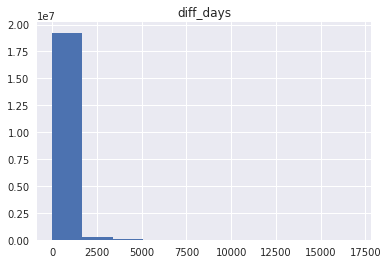

In [45]:
# 분포를 확인.
new_merged.hist(column = 'diff_days')

In [46]:
# future work
# 1. documents_meta에서 방문페이지와 랜딩페이지를 구분해서 발행시간과 이벤트 발생 시간의 차이를 따로 확인해 보기.
# 2. publish_time과 timestamp 모두 to_datetime으로 변환할 때 UTC=True를 적용해보기.
#    - 변환된 시간들을 확인해보니 4시간 정도 유의미한 차이가 있는 것을 확인했다.
#    - 이전에 적용해봤을 때 차이가 없었던 것으로 기억한다.
# 3. 가브리엘 글 참고해서 ads 또는 documents 별 확인.
# 4. 가브리엘의 글에서 ad document가 의미하는 바는 아마 랜딩페이지인 것 같다.
#    - 따라서 documents_meta에서 랜딩페이지의 정보만 추출해서
#    - 위에서 했던 것들을 똑같이 해보면 어떨까?
#    - 하지만 '최신 콘텐츠를 선호하는 유저들은 다른 최신 콘텐츠를 선호할 것이다'와 같은 가정들을 검증하려면, page_views 파일과 merge해야 한다.
#    - 범위를 벗어나는 시간데이터는 모두 NaN값으로 바꾸기

## documents_meta에서 랜딩페이지의 정보만 추출해서 위의 과정을 똑같이 해보기.

In [64]:
# promoted와 event를 document_id를 key로 해서 merge
land_merged = pd.merge(promoted, events, how='inner', on='document_id')

In [65]:
# timestamp를 datetime으로 변환시키는 함수 정의
import datetime
def my_date(raw_date):
  added_date = raw_date + 1465876799998 # timestamp에 캐글 공식 설명에 있던 숫자를 더해줌.
  revised_date = pd.to_datetime((added_date // 1000), unit='s') # '밀리초'를 '초'로 바꾸고, string이기 때문에 unit='s' 옵션 설정 후 datetime으로 변환.
  return revised_date

In [66]:
# 위에서 정의한 함수를 사용하여 변환 후 새로운 변수에 할당.
new_land_merged = land_merged # 데이터프레임을 새로운 변수에 할당.
new_land_merged['new_timestamp'] = my_date(new_land_merged['timestamp'])

In [75]:
new_land_merged.shape

(37071794, 10)

In [67]:
new_land_merged.head()

,ad_id,document_id,campaign_id,advertiser_id,display_id,uuid,timestamp,platform,geo_location,new_timestamp
0,166,47744,37,63,10367595,c999f220b8e2ce,690844180,1,ID>30,2016-06-22 03:54:04
1,167,47804,37,63,13628745,44948933463235,902973104,1,GH>01,2016-06-24 14:49:33
2,167,47804,37,63,13754124,6dd4b7861b8d1d,909004487,1,KE>05,2016-06-24 16:30:04
3,167,47804,37,63,14098790,465c86da01fc18,926626348,3,BN>00,2016-06-24 21:23:46
4,286,55909,37,63,7371436,a9dbf0f1d88d57,505810797,1,US>WV>559,2016-06-20 00:30:10


In [68]:
# 변수별 NaN값 개수 확인
new_land_merged.isnull().sum()

ad_id             0
document_id       0
campaign_id       0
advertiser_id     0
display_id        0
uuid              0
timestamp         0
platform          0
geo_location     31
new_timestamp     0
dtype: int64

In [101]:
# new_land_merged event를 document_id를 key로 해서 merge
new_land_merged2 = pd.merge(new_land_merged, docu_meta, how='inner', on='document_id')

In [102]:
new_land_merged2.head()

,ad_id,document_id,campaign_id,advertiser_id,display_id,uuid,timestamp,platform,geo_location,new_timestamp,source_id,publisher_id,publish_time
0,166,47744,37,63,10367595,c999f220b8e2ce,690844180,1,ID>30,2016-06-22 03:54:04,1907.0,284.0,NaN
1,167,47804,37,63,13628745,44948933463235,902973104,1,GH>01,2016-06-24 14:49:33,1907.0,284.0,NaN
2,167,47804,37,63,13754124,6dd4b7861b8d1d,909004487,1,KE>05,2016-06-24 16:30:04,1907.0,284.0,NaN
3,167,47804,37,63,14098790,465c86da01fc18,926626348,3,BN>00,2016-06-24 21:23:46,1907.0,284.0,NaN
4,286,55909,37,63,7371436,a9dbf0f1d88d57,505810797,1,US>WV>559,2016-06-20 00:30:10,1907.0,284.0,NaN


In [103]:
new_land_merged2.shape

(37071794, 13)

In [111]:
new_land_merged2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37071794 entries, 0 to 37071793
Data columns (total 14 columns):
ad_id               int64
document_id         int64
campaign_id         int64
advertiser_id       int64
display_id          int64
uuid                object
timestamp           int64
platform            object
geo_location        object
new_timestamp       datetime64[ns]
source_id           float64
publisher_id        float64
publish_time        object
new_publish_time    datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(6), object(4)
memory usage: 5.4+ GB


In [105]:
# 1970년 1월 1일 이전에 발행된 글은 29,234개이다.
print(len(new_land_merged2['publish_time'][new_land_merged2['publish_time'] < '1970-01-01 00:00:00']))
# 2016년 6월 28일 이후에 발행된 글들이 175,709개나 된다.
print(len(new_land_merged2['publish_time'][new_land_merged2['publish_time'] > '2016-06-29 00:00:00']))

29234
175709


In [106]:
# 변환 전 NaN값의 개수: 448,283개
new_land_merged2['publish_time'].isnull().sum()

448283

In [107]:
# 1970-01-01 이전에 발행된 글들을 모두 NaN으로 변경.
new_land_merged2['publish_time'][new_land_merged2['publish_time'] < '1970-01-01 00:00:00'] = None

# 2016년 6월 28일 이후에 발행된 글들을 모두 NaN으로 변경.
new_land_merged2['publish_time'][new_land_merged2['publish_time'] > '2016-06-29 00:00:00'] = None

In [108]:
# 변환 후 NaN값의 개수: 653,226개
new_land_merged2['publish_time'].isnull().sum()

653226

In [109]:
# object였던 publish_time의 dtype을 datetime64[ns]로 변경.
new_land_merged2['new_publish_time'] = pd.to_datetime(new_land_merged2['publish_time'], format = '%Y-%m-%d %H:%M:%S')

In [113]:
new_land_merged2.tail()

,ad_id,document_id,campaign_id,advertiser_id,display_id,uuid,timestamp,platform,geo_location,new_timestamp,source_id,publisher_id,publish_time,new_publish_time
37071789,571365,1558759,21001,3410,22133428,9e138a006152ec,1249390584,2,US>NJ>501,2016-06-28 15:03:10,2929.0,252.0,2016-06-01 00:00:00,2016-06-01
37071790,571365,1558759,21001,3410,22982838,d6d8ff79697a31,1288487826,2,US>NJ>504,2016-06-29 01:54:47,2929.0,252.0,2016-06-01 00:00:00,2016-06-01
37071791,572447,994311,7615,12,7590339,1fad2f94776f3d,519840126,1,GB>P2,2016-06-20 04:24:00,14367.0,1235.0,2016-02-26 00:00:00,2016-02-26
37071792,572868,1223296,27613,3123,4918549,944d8a9eadba2e,318157789,2,US>CA>807,2016-06-17 20:22:37,529.0,1165.0,2014-03-12 00:00:00,2014-03-12
37071793,572868,1223296,27613,3123,20654735,983f02d1eb594b,1169637140,1,US>NV>839,2016-06-27 16:53:57,529.0,1165.0,2014-03-12 00:00:00,2014-03-12


In [114]:
new_land_merged2['diff'] = new_land_merged2['new_publish_time'] - new_land_merged2['new_timestamp']

In [116]:
new_land_merged2.tail()

,ad_id,document_id,campaign_id,advertiser_id,display_id,uuid,timestamp,platform,geo_location,new_timestamp,source_id,publisher_id,publish_time,new_publish_time,diff
37071789,571365,1558759,21001,3410,22133428,9e138a006152ec,1249390584,2,US>NJ>501,2016-06-28 15:03:10,2929.0,252.0,2016-06-01 00:00:00,2016-06-01,-28 days +08:56:50
37071790,571365,1558759,21001,3410,22982838,d6d8ff79697a31,1288487826,2,US>NJ>504,2016-06-29 01:54:47,2929.0,252.0,2016-06-01 00:00:00,2016-06-01,-29 days +22:05:13
37071791,572447,994311,7615,12,7590339,1fad2f94776f3d,519840126,1,GB>P2,2016-06-20 04:24:00,14367.0,1235.0,2016-02-26 00:00:00,2016-02-26,-116 days +19:36:00
37071792,572868,1223296,27613,3123,4918549,944d8a9eadba2e,318157789,2,US>CA>807,2016-06-17 20:22:37,529.0,1165.0,2014-03-12 00:00:00,2014-03-12,-829 days +03:37:23
37071793,572868,1223296,27613,3123,20654735,983f02d1eb594b,1169637140,1,US>NV>839,2016-06-27 16:53:57,529.0,1165.0,2014-03-12 00:00:00,2014-03-12,-839 days +07:06:03
